# Rectangular Competitor Comparison

This notebook is identical to competitor-comparison-triangular except this notebook uses a rectangular array of data.
These results are in the paper's appendix.

# Shared Setup

In [1]:
# Generic imports
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from river import linear_model
import copy
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import pickle
import tensorflow as tf
import keras
from keras import layers, regularizers
import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r2jb4oyh because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-10-04 10:23:09.990206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Imports from this project
from models.models import OracleTS, StandardTS, ActionCenteredTS, RoME, IntelligentPooling, UserLaplacian
from models.river_wrapper import RiverBatchEstimator
from models.bagging_mod import BaggingRegressor
from models.utils import find_neighbors
from simulations.data_generator import DataGenerator

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
# Simulation setup: try some different values
N_STAGES = 100
# N_OBSERVATIONS = N_STAGES * (N_STAGES + 1) // 2
N = N_STAGES
T = N_STAGES
THETA = np.array([1., 0.5, -4.])
CONTEXT_DIM = 2
EXTRA_CONTEXT_DIM = 2
LINEAR_BASELINE_COEF = np.array([2., -2., 3.])
THETA_TIME_INIT = np.array([-2., -4., 6.])
P = THETA.size
n_jobs = 25
REPS = 50
N_NEIGHBORS = 5

In [5]:
def get_max_norm(x):
    squared_norms = (x**2).sum(axis=1)
    norms = np.sqrt(squared_norms)
    max_norm = np.max(norms)
    return max_norm

def get_max_norm_for_pairs(x, pairs):
    x_diffs = x[pairs[0]] - x[pairs[1]]
    max_norm = get_max_norm(x_diffs)
    return max_norm

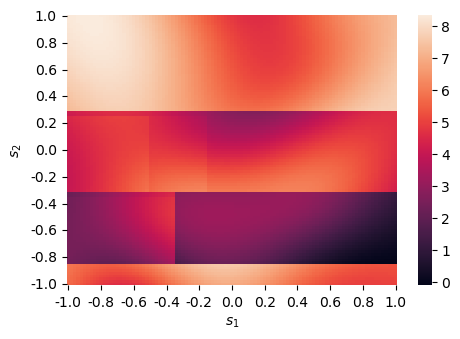

In [6]:
homogeneous_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="homogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
homogeneous_data_generator = homogeneous_data_generator.sample_theta(theta_base=THETA)

heterogeneous_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="heterogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
heterogeneous_data_generator = heterogeneous_data_generator.sample_theta(theta_base=THETA)

nonlinear_data_generator = DataGenerator(n_max=N, t_max=T, assumptions="nonlinear", random_seed=3, nonlinear_scale=1.)  # Seed chosen for its interesting nonlinear relationships
nonlinear_data_generator = nonlinear_data_generator.sample_theta(theta_base=THETA, theta_time_init=THETA_TIME_INIT)

# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)
heatmap_min = np.min(baseline_vals)
heatmap_max = np.max(baseline_vals)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(baseline_vals_df, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/rect_baseline_reward.png")
fig.savefig("figures/rect_baseline_reward.pdf")
plt.show()

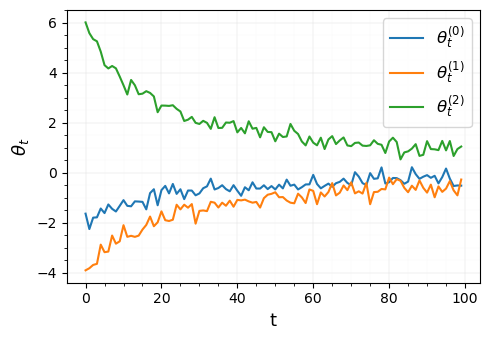

In [7]:
# Time-specifc thetas
fig, ax = plt.subplots(figsize=(5, 3.5))
for i in range(THETA.size):
    label = "$\\theta^{(idx)}_{t}$".replace("idx", str(i))
    ax.plot(nonlinear_data_generator.theta_time[:, i], alpha=1, label=label)
ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
ax.minorticks_on()
ax.set_xlabel("t", fontsize=13)
ax.set_ylabel("$\\theta_{t}$", fontsize=13)
# plt.title("Values of $\\theta_{time}$ Plotted Over Time")
ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig("figures/rect_theta_time.png")
fig.savefig("figures/rect_theta_time.pdf")
plt.show()

2024-10-04 10:23:15.722857: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
50/50 [==============================] - 1s 4ms/step - loss: 2.3421 - val_loss: 1.2633
Epoch 2/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1937 - val_loss: 1.0977
Epoch 3/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1158 - val_loss: 1.0969
Epoch 4/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0917 - val_loss: 1.0525
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0845 - val_loss: 1.0454
Epoch 6/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0882 - val_loss: 1.0713
Epoch 7/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0839 - val_loss: 1.0497
Epoch 8/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0605 - val_loss: 1.0507
Epoch 9/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0870 - val_loss: 1.0340
Epoch 10/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0672 - val_loss: 1.0382
Epoch 11/20
50/50 [

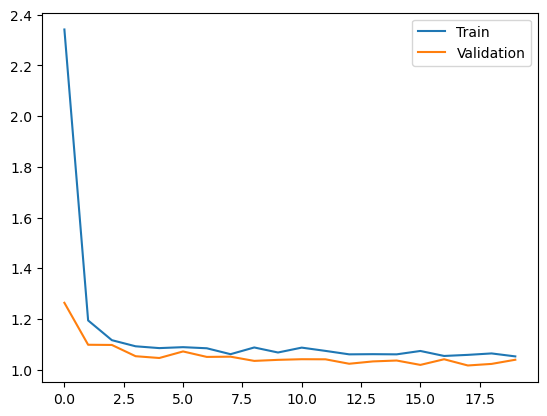

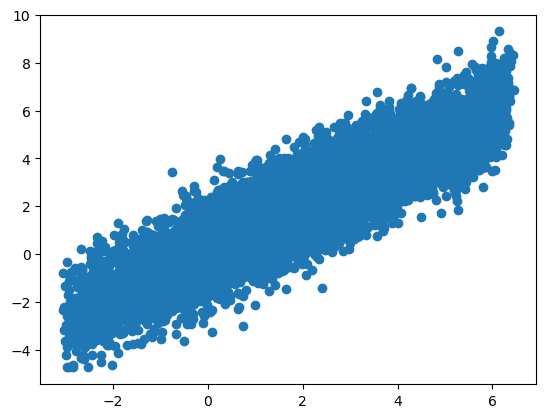

INFO:tensorflow:Assets written to: rect-homogeneous-nn/assets


INFO:tensorflow:Assets written to: rect-homogeneous-nn/assets


Epoch 1/20
50/50 [==============================] - 0s 3ms/step - loss: 2.6292 - val_loss: 1.2694
Epoch 2/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1519 - val_loss: 1.1675
Epoch 3/20
50/50 [==============================] - 0s 2ms/step - loss: 1.1055 - val_loss: 1.1539
Epoch 4/20
50/50 [==============================] - 0s 1ms/step - loss: 1.1006 - val_loss: 1.1282
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0658 - val_loss: 1.0872
Epoch 6/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0407 - val_loss: 1.0690
Epoch 7/20
50/50 [==============================] - 0s 1ms/step - loss: 1.0509 - val_loss: 1.0858
Epoch 8/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0508 - val_loss: 1.0604
Epoch 9/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0432 - val_loss: 1.0612
Epoch 10/20
50/50 [==============================] - 0s 2ms/step - loss: 1.0352 - val_loss: 1.0855
Epoch 11/20
50/50 [

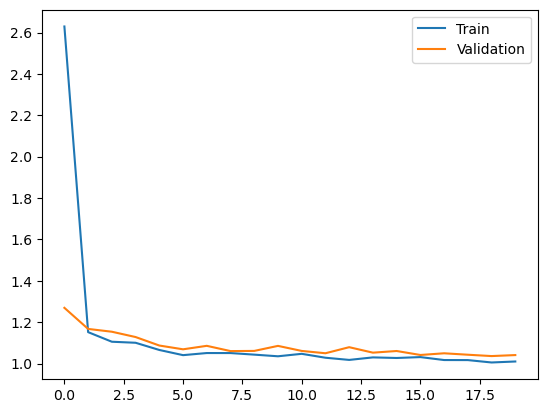

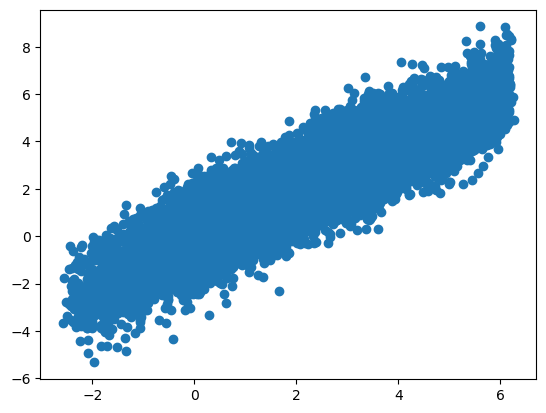

INFO:tensorflow:Assets written to: rect-heterogeneous-nn/assets


INFO:tensorflow:Assets written to: rect-heterogeneous-nn/assets


Epoch 1/50
50/50 [==============================] - 0s 3ms/step - loss: 7.9114 - val_loss: 4.7256
Epoch 2/50
50/50 [==============================] - 0s 2ms/step - loss: 4.7252 - val_loss: 4.7069
Epoch 3/50
50/50 [==============================] - 0s 2ms/step - loss: 4.4843 - val_loss: 3.4458
Epoch 4/50
50/50 [==============================] - 0s 2ms/step - loss: 3.0971 - val_loss: 2.7433
Epoch 5/50
50/50 [==============================] - 0s 2ms/step - loss: 2.8748 - val_loss: 2.5855
Epoch 6/50
50/50 [==============================] - 0s 2ms/step - loss: 2.6177 - val_loss: 2.3841
Epoch 7/50
50/50 [==============================] - 0s 2ms/step - loss: 2.4275 - val_loss: 2.2507
Epoch 8/50
50/50 [==============================] - 0s 2ms/step - loss: 2.3347 - val_loss: 2.1034
Epoch 9/50
50/50 [==============================] - 0s 2ms/step - loss: 2.1676 - val_loss: 2.0522
Epoch 10/50
50/50 [==============================] - 0s 2ms/step - loss: 2.0776 - val_loss: 1.9641
Epoch 11/50
50/50 [

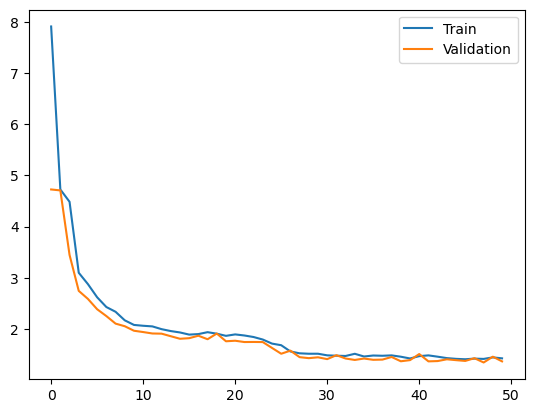

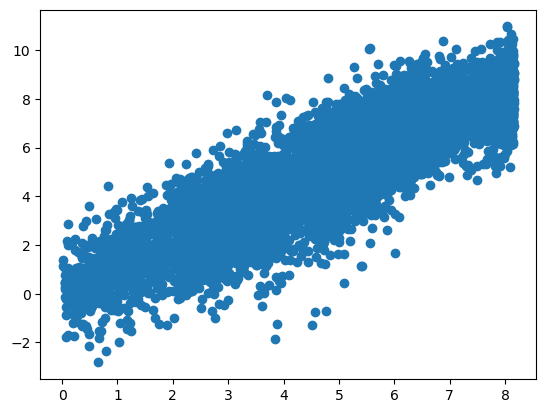

INFO:tensorflow:Assets written to: rect-nonlinear-nn/assets


INFO:tensorflow:Assets written to: rect-nonlinear-nn/assets


CPU times: user 15.5 s, sys: 4.88 s, total: 20.4 s
Wall time: 11.6 s


In [8]:
%%time
# Neural network stuff
nn_input_dim = CONTEXT_DIM + EXTRA_CONTEXT_DIM

data_generators = [homogeneous_data_generator, heterogeneous_data_generator, nonlinear_data_generator]
model_files = ["rect-homogeneous-nn", "rect-heterogeneous-nn", "rect-nonlinear-nn"]
for i, (data_generator, model_file) in enumerate(zip(data_generators, model_files)):
    # Create data
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_train, y_train = data_generator.generate_baselines_for_nn()
    
    data_generator = data_generator.reset()
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_validation, y_validation = data_generator.generate_baselines_for_nn()
    
    # Train model
    penalty = 0.001
    nn_output_dim = 10
    model = keras.Sequential(
        [
            keras.Input(shape=(nn_input_dim,), name="input"),
            layers.Dense(10, activation="relu", name="layer1", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="relu", name="layer2", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="tanh", name="layer3", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(nn_output_dim, activation="tanh", name="layer4", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(1, name="output", kernel_regularizer=regularizers.l2(penalty)),
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=opt)
    history = model.fit(
        X_train,
        y_train,
        batch_size=200,
        validation_data=(X_validation, y_validation),
        epochs=50 if i == 2 else 20,
        # epochs=1,
        verbose=1
    )
    
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.legend()
    plt.show()

    preds_validation = model(X_validation)
    plt.scatter(preds_validation, y_validation)
    plt.show()
    
    # Featurizer model
    featurizer_nn_model = keras.Model(
        inputs=model.input,
        outputs=model.get_layer("layer4").output)
    featurizer_nn_model.compile()
    featurizer_nn_model.save(model_file)

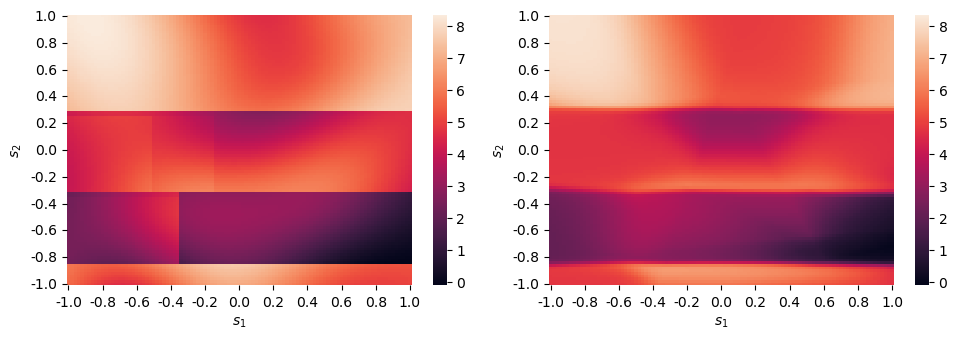

In [9]:
# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
sns.heatmap(baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_xlabel("$s_{1}$")
ax[0].set_ylabel("$s_{2}$")

nn_context_values = np.hstack([context_values, np.zeros_like(context_values)])
nn_baseline_vals = model(nn_context_values).numpy()
nn_baseline_vals_df = pd.DataFrame(
    data=nn_baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_xlabel("$s_{1}$")
ax[1].set_ylabel("$s_{2}$")

fig.tight_layout()
fig.savefig("figures/rect_nn_baseline_reward_comparison.png")
fig.savefig("figures/rect_nn_baseline_reward_comparison.pdf")
plt.show()

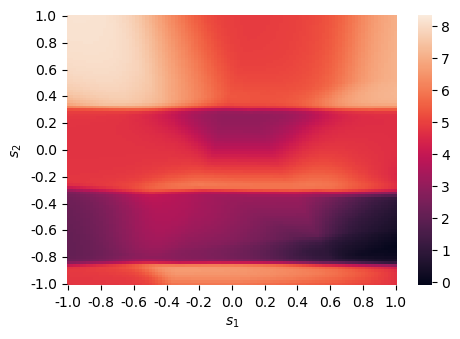

In [10]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/rect_nn_baseline_reward.png")
fig.savefig("figures/rect_nn_baseline_reward.pdf")
plt.show()

In [11]:
# This determines the plotting order
non_oracle_method_names = [
    "IntelPooling",
    "RoME-BLM",
    "RoME",
    "RoME-SU",
    "AC",
    "Standard",
    "Neural-Linear",
    "NNR-Linear"
]

def create_reward_dict(data_generator, nn_model_name, seed):
    np.random.seed(seed)
    user_pairs, L_user = find_neighbors(data_generator.theta_user, N_NEIGHBORS)
    time_pairs, L_time = find_neighbors(data_generator.theta_time, N_NEIGHBORS)
    
    # Doubling these values to make them more reasonable
    d_user = get_max_norm(data_generator.theta_user) * 2
    d_time = get_max_norm(data_generator.theta_time) * 2
    b_user = get_max_norm_for_pairs(data_generator.theta_user, user_pairs) * 2
    b_time = get_max_norm_for_pairs(data_generator.theta_time, time_pairs) * 2
    bagged_lm = RiverBatchEstimator(
        BaggingRegressor(
            linear_model.LinearRegression(l2=1e-8, intercept_lr=0.1),
            n_models=10,
            subsample=0.8
        )
    )

    # Set covariances
    cov_epsilon = 1e-18
    user_cov = np.cov(data_generator.theta_user.T)
    if user_cov.sum() < cov_epsilon:
        user_cov += cov_epsilon * np.eye(user_cov.shape[0])
    time_cov = np.cov(data_generator.theta_time.T)
    if time_cov.sum() < cov_epsilon:
        time_cov += cov_epsilon * np.eye(time_cov.shape[0])

    nn = tf.keras.models.load_model(nn_model_name)
    nn_numpy = lambda x: nn(x).numpy()
    
    non_oracle_methods_dict = {
        "IntelPooling": IntelligentPooling(N, T, P, DataGenerator._featurize, user_cov=user_cov, time_cov=time_cov),
        "RoME": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS),
        "RoME-BLM": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, ml_interactions=True, ml_model=bagged_lm, n_neighbors=N_NEIGHBORS),
        "RoME-SU": RoME(1, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS, pool_users=False),
        "AC": ActionCenteredTS(N, T, P, DataGenerator._featurize),
        "Standard": StandardTS(N, T, P, DataGenerator._featurize),
        "Neural-Linear": StandardTS(N, T, P, DataGenerator._featurize, nn=nn_numpy, nn_dim=nn_output_dim),
        "NNR-Linear": UserLaplacian(N, T, P, DataGenerator._featurize, L_user, user_cov=user_cov),
    }
    methods_dict = copy.copy(non_oracle_methods_dict)
    methods_dict["Oracle"] = OracleTS(N, T, THETA, data_generator.theta_user, data_generator.theta_time, DataGenerator._featurize)
    
    # Dictionary for storing rewards
    rewards_dict = {k:np.zeros((N, T)) for k in methods_dict}
    timings_dict = {}

    # Generate context vectors that we'll use for all models
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)

    # Iterate through methods
    for method_name, method in methods_dict.items():
        rewards = []
        data_generator = data_generator.reset()
        method.reset()
        method_start_time = time.time()

        while not data_generator.finished:
            # Randomly samples action from current policy
            context, context_extra, user_idx, time_idx = data_generator.get_current_context()
            action = method.sample_action(context, user_idx, time_idx)

            # Plays action and returns reward
            reward = data_generator.play_action(action)
            rewards_dict[method_name][user_idx, time_idx] = reward

            # Update method inferences
            method.update(context, context_extra, user_idx, time_idx, action, reward)
        method_end_time = time.time()
        method_elapsed_time = method_end_time - method_start_time
        timings_dict[method_name] = method_elapsed_time

    return rewards_dict, timings_dict

In [12]:
def run_simulation(data_generator, nn_model_name, REPS=REPS, n_jobs=cpu_count()):    
    # Perform whole simulation REPS times
    pool_args = zip(
        [copy.deepcopy(data_generator) for _ in range(REPS)],
        [nn_model_name]*REPS,
        range(REPS))
    print("Starting parallel")
    list_of_tuples_of_dicts = Parallel(n_jobs=n_jobs)(delayed(create_reward_dict)(*arg) for arg in pool_args)    
    print("Parallel closed")
    rewards_list_of_dicts = [t[0] for t in list_of_tuples_of_dicts]
    timings_list_of_dicts = [t[1] for t in list_of_tuples_of_dicts]
    rewards_dict = {}
    timings_dict = {}
    method_names = list(rewards_list_of_dicts[0].keys())
    non_oracle_method_names = list(set(method_names) - set(["Oracle"]))
    for method_name in method_names:
        rewards_dict[method_name] = np.asarray([
            rewards_list_of_dicts[i][method_name]
            for i in range(REPS)])
        timings_dict[method_name] = np.asarray([
            timings_list_of_dicts[i][method_name]
            for i in range(REPS)])
                
    return rewards_dict, timings_dict

In [13]:
def get_avg_time_reward(a):
    return a.mean(axis=1)

def plot_rewards_dict(rewards_dict, assumptions):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax0 = ax[0]
    ax1 = ax[1]
    
    # Calculate incremental regret
    oracle_incremental_regret = get_avg_time_reward(rewards_dict["Oracle"])
    incremental_regret_dict = {
        method_name: (oracle_incremental_regret - get_avg_time_reward(rewards_dict[method_name])).mean(axis=0)  # Mean over reps
        for method_name in non_oracle_method_names}

    # Calculate cumulative regret
    cumulative_regret_dict = {method_name: np.cumsum(incremental_regret_dict[method_name]) for method_name in non_oracle_method_names}

    # Plot incremental regret
    for method_name in non_oracle_method_names:
        ax0.plot(incremental_regret_dict[method_name], label=method_name)
    ax0.set_title("(a) Incremental Regret Over Time", pad=10)
    ax0.set_ylabel("Incremental Regret")
    ax0.set_xlabel("Time")
    ax0.legend()

    # Plot cumulative regret
    for method_name in non_oracle_method_names:
        ax1.plot(cumulative_regret_dict[method_name], label=method_name)
    ax1.set_title("(b) Cumulative Regret Over Time", pad=10)
    ax1.set_ylabel("Cumulative Regret")
    ax1.set_xlabel("Time")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.savefig(f"figures/rectangular-{assumptions}-regret.png")
    fig.savefig(f"figures/rectangular-{assumptions}-regret.pdf")
    fig.suptitle(f"Regret for {assumptions.capitalize()} Data-Generating Process")
    plt.show()

# Simulation 1: Homogeneous Users, Linear Baseline, No Time Effects

In [14]:
%%time
homogeneous_rewards_dict, homogeneous_timings_dict = run_simulation(homogeneous_data_generator, model_files[0], n_jobs=n_jobs)

Starting parallel


2024-10-04 10:23:32.316597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:23:32.318165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:23:32.322942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 497 ms, sys: 504 ms, total: 1 s
Wall time: 15min 53s


In [15]:
def print_timings(timings_dict_):
    print("Average elapsed time by method")
    for k in timings_dict_:
        mean_timing = timings_dict_[k].mean()
        print(f"{k}: {mean_timing}")
    timings_df = pd.DataFrame(timings_dict_)
    print(timings_df)
    return timings_df
print_timings(homogeneous_timings_dict)

Average elapsed time by method
IntelPooling: 16.663880095481872
RoME: 156.27323665618897
RoME-BLM: 15.93919373035431
RoME-SU: 164.26283943653107
AC: 0.08772886753082275
Standard: 0.11634754657745361
Neural-Linear: 0.5684848451614379
NNR-Linear: 13.795412259101868
Oracle: 0.014561877250671387
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      18.287364  142.671408  16.283659  153.528990  0.087762  0.117441   
1      17.955644  146.278247  15.829741  160.743013  0.087202  0.116692   
2      16.084236  147.426191  15.739338  158.842100  0.086979  0.115417   
3      18.230069  144.179561  16.033901  161.906678  0.087112  0.114638   
4      17.609533  148.995233  15.711842  158.929975  0.087448  0.116518   
5      18.082534  149.600299  15.885070  162.473588  0.086900  0.114684   
6      18.250762  147.724818  16.183258  156.191267  0.089257  0.116854   
7      16.994725  145.652915  16.025944  155.362096  0.087716  0.115093   
8      18.239245  145.845047  16

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,18.287364,142.671408,16.283659,153.528990,0.087762,0.117441,0.590496,13.941223,0.014782
1,17.955644,146.278247,15.829741,160.743013,0.087202,0.116692,0.588235,13.747600,0.014653
2,16.084236,147.426191,15.739338,158.842100,0.086979,0.115417,0.589835,13.727064,0.014282
3,18.230069,144.179561,16.033901,161.906678,0.087112,0.114638,0.587897,13.572849,0.014104
4,17.609533,148.995233,15.711842,158.929975,0.087448,0.116518,0.594094,13.776175,0.014234
5,18.082534,149.600299,15.885070,162.473588,0.086900,0.114684,0.598817,13.729869,0.014410
6,18.250762,147.724818,16.183258,156.191267,0.089257,0.116854,0.604590,13.876208,0.014726
7,16.994725,145.652915,16.025944,155.362096,0.087716,0.115093,0.584096,13.735536,0.014520
8,18.239245,145.845047,16.428540,158.477517,0.091471,0.118374,0.592382,13.982399,0.014912
9,17.742755,147.062867,15.717910,158.298109,0.086586,0.115433,0.588267,13.629570,0.014028


In [16]:
homogeneous_rewards_filename = "checkpoints/rectangular_homogeneous_rewards.pkl"
with open(homogeneous_rewards_filename, 'wb') as file:
    pickle.dump(homogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open(homogeneous_rewards_filename, "rb") as file:
    homogeneous_rewards_dict = pickle.load(file)

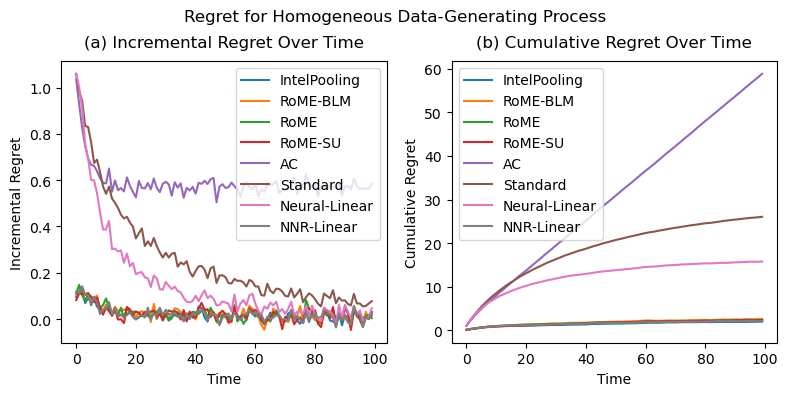

In [18]:
plot_rewards_dict(homogeneous_rewards_dict, "homogeneous")

# Simulation 2: Heterogeneous Users, Linear Baseline, No Time Effects

In [19]:
%%time
heterogeneous_rewards_dict, heterogeneous_timings_dict = run_simulation(heterogeneous_data_generator, model_files[1], n_jobs=n_jobs)

Starting parallel


2024-10-04 10:39:39.388764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:39:39.398204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:39:39.401473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 542 ms, sys: 606 ms, total: 1.15 s
Wall time: 16min 11s


In [20]:
print_timings(heterogeneous_timings_dict)

Average elapsed time by method
IntelPooling: 16.00910077095032
RoME: 157.19487830638886
RoME-BLM: 16.067612371444703
RoME-SU: 164.15854181289671
AC: 0.08805453777313232
Standard: 0.11656764507293702
Neural-Linear: 0.5728630495071411
NNR-Linear: 13.924551820755005
Oracle: 0.014527044296264648
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      15.949093  143.255503  15.950054  150.867672  0.088869  0.116450   
1      15.987366  150.513023  16.158250  161.270756  0.093786  0.122003   
2      17.010315  145.481934  17.315321  154.997520  0.087915  0.115569   
3      16.243209  144.446726  16.042428  155.804322  0.088088  0.116390   
4      15.866510  144.864483  16.188578  157.820905  0.089774  0.115813   
5      15.930707  150.737705  15.892435  161.102404  0.089028  0.117130   
6      15.774823  152.410156  16.040622  164.354736  0.089025  0.116532   
7      16.163810  148.550004  16.185019  157.249017  0.087134  0.115953   
8      16.089661  145.013483  16

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,15.949093,143.255503,15.950054,150.867672,0.088869,0.116450,0.595231,13.919233,0.014213
1,15.987366,150.513023,16.158250,161.270756,0.093786,0.122003,0.628607,15.301187,0.016383
2,17.010315,145.481934,17.315321,154.997520,0.087915,0.115569,0.602764,13.902400,0.014138
3,16.243209,144.446726,16.042428,155.804322,0.088088,0.116390,0.597600,13.844049,0.014440
4,15.866510,144.864483,16.188578,157.820905,0.089774,0.115813,0.594488,13.952872,0.014046
5,15.930707,150.737705,15.892435,161.102404,0.089028,0.117130,0.598608,13.721277,0.014911
6,15.774823,152.410156,16.040622,164.354736,0.089025,0.116532,0.615345,13.841509,0.014452
7,16.163810,148.550004,16.185019,157.249017,0.087134,0.115953,0.593958,14.008075,0.014519
8,16.089661,145.013483,16.332490,156.717078,0.088350,0.116887,0.587847,13.899831,0.014930
9,15.978919,145.233027,16.157018,156.216478,0.088395,0.116965,0.593303,13.640398,0.014460


In [21]:
heterogeneous_rewards_filename = "checkpoints/rectangular_heterogeneous_rewards.pkl"
with open(heterogeneous_rewards_filename, 'wb') as file:
    pickle.dump(heterogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open(heterogeneous_rewards_filename, "rb") as file:
    heterogeneous_rewards_dict = pickle.load(file)

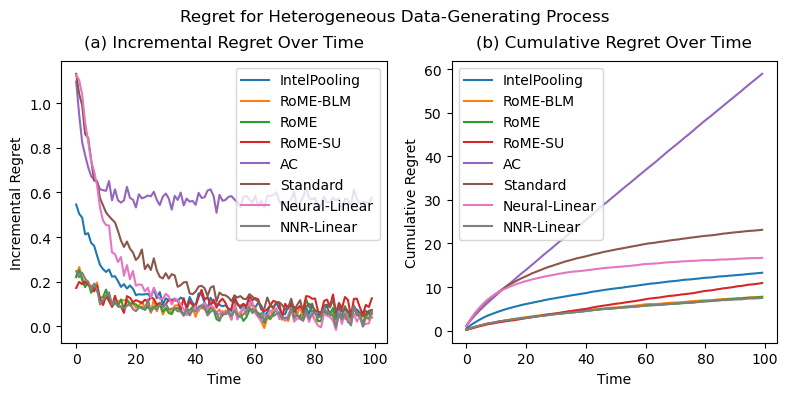

In [23]:
plot_rewards_dict(heterogeneous_rewards_dict, "heterogeneous")

# Simulation 3: Nonlinear Baseline and User-/Time-specific Effects

In [24]:
%%time
nonlinear_rewards_dict, nonlinear_timings_dict = run_simulation(nonlinear_data_generator, model_files[2], n_jobs=n_jobs)

Starting parallel


2024-10-04 10:55:41.420825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:55:41.577095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:55:41.591050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 553 ms, sys: 612 ms, total: 1.16 s
Wall time: 17min 47s


In [25]:
print_timings(nonlinear_timings_dict)

Average elapsed time by method
IntelPooling: 16.23447992801666
RoME: 160.59171765327454
RoME-BLM: 16.232287769317626
RoME-SU: 169.00926366329193
AC: 0.2205600595474243
Standard: 0.24882188320159912
Neural-Linear: 0.7092822027206421
NNR-Linear: 14.07883828163147
Oracle: 0.14112608432769774
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      16.768867  151.160994  15.963169  161.211988  0.215675  0.243607   
1      16.174948  151.146752  16.385488  161.440569  0.214515  0.243100   
2      16.142187  150.963094  16.258796  162.009593  0.219453  0.248361   
3      16.016333  144.647573  16.157383  157.337083  0.219387  0.246292   
4      16.148654  149.047028  16.264432  159.036204  0.219305  0.246377   
5      16.144425  147.660171  16.118000  163.690313  0.221452  0.248965   
6      16.042949  152.719386  16.006346  170.120809  0.222603  0.245212   
7      16.086594  148.664253  16.268758  176.214196  0.228289  0.255729   
8      16.215637  150.024977  16.43

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,16.768867,151.160994,15.963169,161.211988,0.215675,0.243607,0.722623,13.687621,0.136714
1,16.174948,151.146752,16.385488,161.440569,0.214515,0.243100,0.717088,13.837987,0.134172
2,16.142187,150.963094,16.258796,162.009593,0.219453,0.248361,0.730449,14.063083,0.140829
3,16.016333,144.647573,16.157383,157.337083,0.219387,0.246292,0.727759,13.714163,0.137979
4,16.148654,149.047028,16.264432,159.036204,0.219305,0.246377,0.731060,13.908662,0.137942
5,16.144425,147.660171,16.118000,163.690313,0.221452,0.248965,0.738541,13.995649,0.140568
6,16.042949,152.719386,16.006346,170.120809,0.222603,0.245212,0.732728,13.827189,0.140251
7,16.086594,148.664253,16.268758,176.214196,0.228289,0.255729,0.760378,14.878036,0.141728
8,16.215637,150.024977,16.439055,163.987217,0.220851,0.247946,0.731030,14.059115,0.140831
9,16.110380,149.378035,16.188473,163.665067,0.221485,0.248942,0.732658,13.997555,0.141081


In [26]:
nonlinear_rewards_filename = "checkpoints/rectangular_nonlinear_rewards.pkl"
with open(nonlinear_rewards_filename, 'wb') as file:
    pickle.dump(nonlinear_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open(nonlinear_rewards_filename, "rb") as file:
    nonlinear_rewards_dict = pickle.load(file)

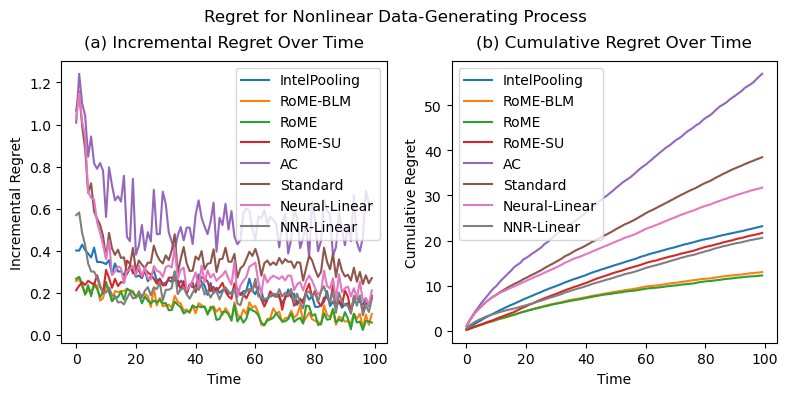

In [28]:
plot_rewards_dict(nonlinear_rewards_dict, "nonlinear")

# Cumulative Regret for All Three Settings

## Calculations

In [29]:
# Calculate incremental regret
incremental_homogeneous_regret_dict = {
    method_name: get_avg_time_reward(homogeneous_rewards_dict["Oracle"]) - get_avg_time_reward(homogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_heterogeneous_regret_dict = {
    method_name: get_avg_time_reward(heterogeneous_rewards_dict["Oracle"]) - get_avg_time_reward(heterogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_nonlinear_regret_dict = {
    method_name: get_avg_time_reward(nonlinear_rewards_dict["Oracle"]) - get_avg_time_reward(nonlinear_rewards_dict[method_name])
    for method_name in non_oracle_method_names}

# Calculate cumulative regret
cumulative_homogeneous_regret_dict = {method_name: np.cumsum(incremental_homogeneous_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}
cumulative_heterogeneous_regret_dict = {method_name: np.cumsum(incremental_heterogeneous_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}
cumulative_nonlinear_regret_dict = {method_name: np.cumsum(incremental_nonlinear_regret_dict[method_name], axis=1) for method_name in non_oracle_method_names}

# Final regret
final_homogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_homogeneous_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_homogeneous_regret_df.to_csv("./checkpoints/rectangular_final_homogeneous_regret.csv", index=False)

final_heterogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_heterogeneous_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_heterogeneous_regret_df.to_csv("./checkpoints/rectangular_final_heterogeneous_regret.csv", index=False)

final_nonlinear_regret_df = pd.DataFrame({
    method_name: cumulative_nonlinear_regret_dict[method_name][:, -1]
    for method_name in non_oracle_method_names})
final_nonlinear_regret_df.to_csv("./checkpoints/rectangular_final_nonlinear_regret.csv", index=False)

## Plots

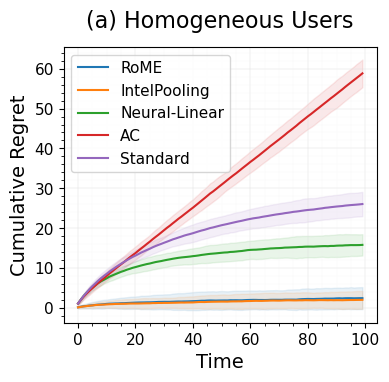

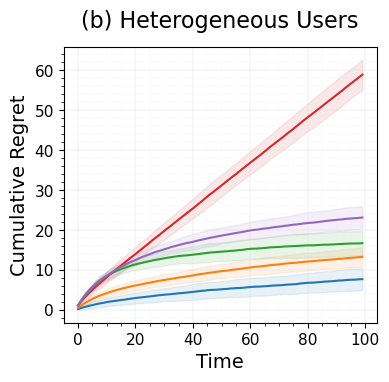

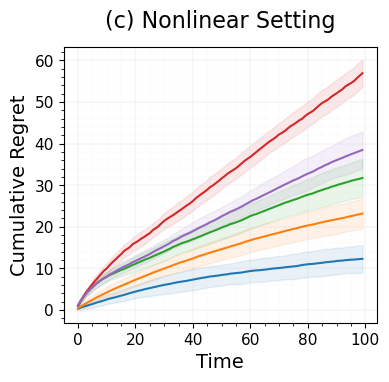

In [30]:
def plot_cumulative_regret(cumulative_regret_dict, setting_name, include_legend=False, loc="main", include_bands=True):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    for i, method_name in enumerate(cumulative_regret_dict.keys()):
        color_i = f"C{i}"
        method_means = cumulative_regret_dict[method_name].mean(axis=0)
        method_range = np.arange(method_means.size)
        method_sds = cumulative_regret_dict[method_name].std(axis=0)
        method_lower = method_means - 1.96 * method_sds
        method_upper = method_means + 1.96 * method_sds
        if include_bands:
            ax.fill_between(method_range, method_lower, method_upper, color=color_i, alpha=0.1)
        ax.plot(method_range, method_means, label=method_name, color=color_i)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
    ax.minorticks_on()
    ax.set_title(setting_name, pad=14, fontsize=16)
    ax.set_ylabel("Cumulative Regret", fontsize=14)
    ax.set_xlabel("Time", fontsize=14)
    ax.tick_params(axis='both', labelsize=11)
    if include_legend:
        ax.legend(fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    setting_name_for_file = setting_name.replace("(", "").replace(")", "").replace(" ", "-")
    fig.savefig(f"figures/rectangular-cumulative-regret-{setting_name_for_file}-{loc}.png")
    fig.savefig(f"figures/rectangular-cumulative-regret-{setting_name_for_file}-{loc}.pdf")
    # fig.suptitle("Comparison of Cumulative Regret by Method")
    plt.show()

main_paper_methods = ["RoME", "IntelPooling", "Neural-Linear", "AC", "Standard"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(a) Homogeneous Users", include_legend=True)

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False)

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in main_paper_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False)

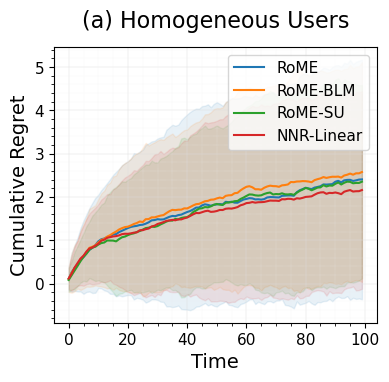

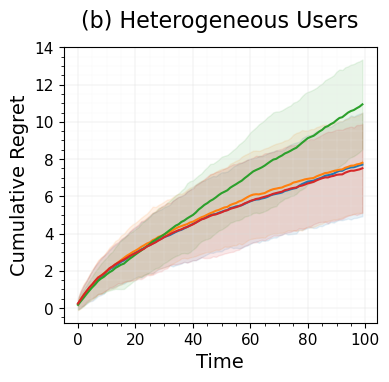

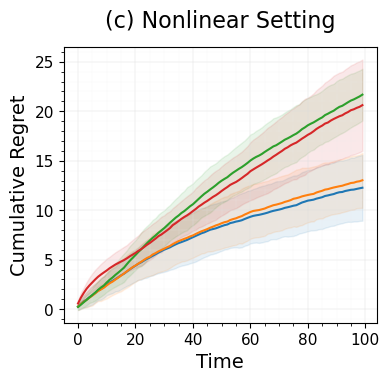

In [31]:
appendix_methods = ["RoME", "RoME-BLM", "RoME-SU", "NNR-Linear"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(a) Homogeneous Users", include_legend=True, loc="app")

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False, loc="app")

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in appendix_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False, loc="app")

## Comparison Tables

### Extra

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
final_homogeneous_regret_df = pd.read_csv("./checkpoints/rectangular_final_homogeneous_regret.csv")
final_heterogeneous_regret_df = pd.read_csv("./checkpoints/rectangular_final_heterogeneous_regret.csv")
final_nonlinear_regret_df = pd.read_csv("./checkpoints/rectangular_final_nonlinear_regret.csv")

In [34]:
non_oracle_method_names_sorted = [
    'RoME',
    'RoME-BLM',
    'RoME-SU',
    'NNR-Linear',
    'IntelPooling',
    'Neural-Linear',
    'Standard',
    'AC',
]

In [35]:
def create_comparison_df(final_regret_df):
    comparison_outer_list = []
    win_percentages = []
    for method_row in non_oracle_method_names_sorted:
        comparison_inner_list = []
        win_percentage = 0.
        for method_column in non_oracle_method_names_sorted:
            diffs = final_regret_df[method_column] - final_regret_df[method_row]
            percent_row_better = np.mean(diffs > 0)
            avg_diff = np.mean(diffs)
            p_value = ttest_1samp(diffs, popmean=0).pvalue
            if method_row == method_column:
                cell_text = "-"
            else:
                win_percentage += percent_row_better / (len(non_oracle_method_names_sorted) - 1)
                cell_text = f"{percent_row_better:.0%}{'*' if p_value < 0.05 else ''}"
            comparison_inner_list.append(cell_text)
        comparison_outer_list.append(comparison_inner_list)
        win_percentages.append(f"{win_percentage:.0%}")
    comparison_df = pd.DataFrame(
        comparison_outer_list,
        index=[f"{i+1}. {n}" for i, n in enumerate(non_oracle_method_names_sorted)],
        columns=range(1, len(non_oracle_method_names_sorted)+1))
    comparison_df["\textbf{Avg}"] = win_percentages
    latex_table = comparison_df.to_latex(escape=False).replace("%", "\%")
    print(latex_table)
    return comparison_df

In [36]:
homogeneous_comparison_df = create_comparison_df(final_homogeneous_regret_df)
homogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 56\% & 44\% & 42\% & 38\% & 100\%* & 100\%* & 100\%* & 69\% \\
2. RoME-BLM & 44\% & - & 44\% & 40\%* & 32\%* & 100\%* & 100\%* & 100\%* & 66\% \\
3. RoME-SU & 56\% & 56\% & - & 44\% & 36\% & 100\%* & 100\%* & 100\%* & 70\% \\
4. NNR-Linear & 58\% & 60\%* & 56\% & - & 52\% & 100\%* & 100\%* & 100\%* & 75\% \\
5. IntelPooling & 62\% & 68\%* & 64\% & 48\% & - & 100\%* & 100\%* & 100\%* & 77\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,56%,44%,42%,38%,100%*,100%*,100%*,69%
2. RoME-BLM,44%,-,44%,40%*,32%*,100%*,100%*,100%*,66%
3. RoME-SU,56%,56%,-,44%,36%,100%*,100%*,100%*,70%
4. NNR-Linear,58%,60%*,56%,-,52%,100%*,100%*,100%*,75%
5. IntelPooling,62%,68%*,64%,48%,-,100%*,100%*,100%*,77%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [37]:
heterogeneous_comparison_df = create_comparison_df(final_heterogeneous_regret_df)
heterogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 60\% & 100\%* & 42\% & 100\%* & 100\%* & 100\%* & 100\%* & 86\% \\
2. RoME-BLM & 40\% & - & 100\%* & 34\% & 100\%* & 100\%* & 100\%* & 100\%* & 82\% \\
3. RoME-SU & 0\%* & 0\%* & - & 2\%* & 92\%* & 100\%* & 100\%* & 100\%* & 56\% \\
4. NNR-Linear & 58\% & 66\% & 98\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 89\% \\
5. IntelPooling & 0\%* & 0\%* & 8\%* & 0\%* & - & 98\%* & 100\%* & 100\%* & 44\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,60%,100%*,42%,100%*,100%*,100%*,100%*,86%
2. RoME-BLM,40%,-,100%*,34%,100%*,100%*,100%*,100%*,82%
3. RoME-SU,0%*,0%*,-,2%*,92%*,100%*,100%*,100%*,56%
4. NNR-Linear,58%,66%,98%*,-,100%*,100%*,100%*,100%*,89%
5. IntelPooling,0%*,0%*,8%*,0%*,-,98%*,100%*,100%*,44%
6. Neural-Linear,0%*,0%*,0%*,0%*,2%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


### Nonlinear Setting

In [38]:
nonlinear_comparison_df = create_comparison_df(final_nonlinear_regret_df)
nonlinear_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 64\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 95\% \\
2. RoME-BLM & 36\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 100\%* & 91\% \\
3. RoME-SU & 0\%* & 0\%* & - & 28\%* & 74\%* & 100\%* & 100\%* & 100\%* & 57\% \\
4. NNR-Linear & 0\%* & 0\%* & 72\%* & - & 86\%* & 100\%* & 100\%* & 100\%* & 65\% \\
5. IntelPooling & 0\%* & 0\%* & 26\%* & 14\%* & - & 98\%* & 100\%* & 100\%* & 48\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,64%*,100%*,100%*,100%*,100%*,100%*,100%*,95%
2. RoME-BLM,36%*,-,100%*,100%*,100%*,100%*,100%*,100%*,91%
3. RoME-SU,0%*,0%*,-,28%*,74%*,100%*,100%*,100%*,57%
4. NNR-Linear,0%*,0%*,72%*,-,86%*,100%*,100%*,100%*,65%
5. IntelPooling,0%*,0%*,26%*,14%*,-,98%*,100%*,100%*,48%
6. Neural-Linear,0%*,0%*,0%*,0%*,2%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [39]:
final_nonlinear_regret_df

,IntelPooling,RoME-BLM,RoME,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear
0,20.750056,12.253496,15.071509,19.791147,55.418016,38.858717,30.011894,18.713533
1,23.075972,14.117008,16.660643,20.854914,60.200479,37.268335,36.159367,20.643185
2,22.488947,13.802793,12.128633,22.686135,57.657632,36.369381,31.035272,16.256672
3,23.329528,13.784448,12.221044,22.905026,57.587548,42.192936,33.796411,26.742274
4,25.477184,13.629902,15.695448,21.371799,54.717784,38.816484,31.927086,22.928075
5,22.790752,13.073129,13.066306,25.180655,55.529013,37.424068,31.700295,20.216187
6,26.939415,12.441511,12.116356,20.091815,55.636098,36.685831,25.419286,18.945543
7,24.098015,13.579260,11.951434,22.803673,60.394387,40.218562,31.644457,21.150411
8,23.659394,12.396987,13.944428,19.989419,57.434940,38.943138,33.609150,18.368224
9,22.609428,10.741558,12.893610,22.168661,57.143249,35.887057,32.548289,20.687237


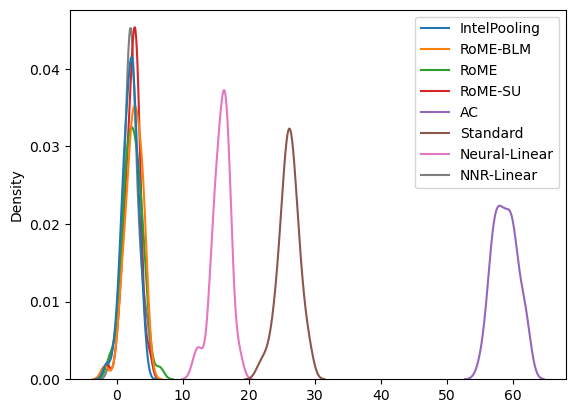

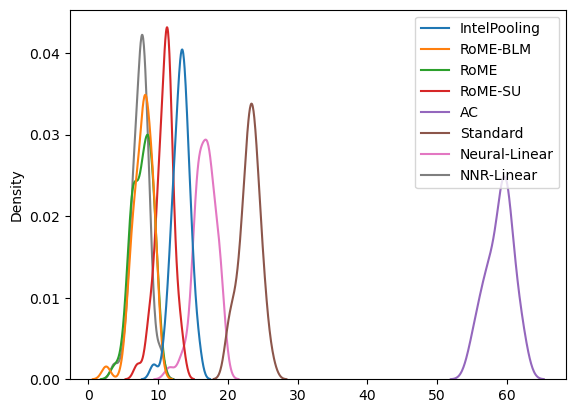

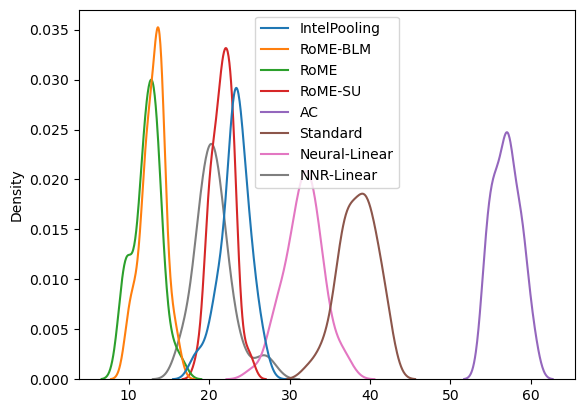

In [40]:
sns.kdeplot(data=final_homogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_heterogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_nonlinear_regret_df)
plt.show()